## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""

def build_mlp(input_shape, regular, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    print(ratio)
    if regular == 0:
            
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
                
    elif regular == 1:
        
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(l1=ratio[0],l2=ratio[1]))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1=ratio[0],l2=ratio[1]))(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
l1_list = [1e-2, 1e-4, 1e-8]
l1_l2_list = [ [1e-2,1e-2], [1e-4,1e-4], [1e-8,1e-8] ]


In [9]:
results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

ii = 0
    
for regularizer_ratio in l1_list:
    keras.backend.clear_session() # 把舊的 Graph 清掉

    print("Experiment with regularizer = %.6f" % (regularizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], regular=ii,ratio=regularizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]


    exp_name_tag = "exp-l1-" + str(regularizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with regularizer = 0.010000
0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 141us/step - loss: 6.0244 - acc: 0.2681 - val_loss: 5.8200 - val_acc: 0.3378
Epoch 2/50
50000/50000 [==============================] - 6s 129us/step - loss: 5.7352 - acc: 0.3590 - val_loss: 5.6556 - val_acc: 0.3728
Epoch 3/50
50000/50000 [==============================] - 6s 129us/step - loss: 5.5879 - acc: 0.3916 - val_loss: 5.5236 - val_acc: 0.4038
Epoch 4/50
50000/50000 [==============================] - 7s 134us/step - loss: 5.4661 - acc: 0.4105 - val_loss: 5.4092 - val_acc: 0.4220
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 5.3566 - acc: 0.4296 - val_loss: 5.3085 - val_acc: 0.4285
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.2546 - acc: 0.4426 - val_loss: 5.2126 - val_acc: 0.4444
Epoch 7/50
50000/50000 [==============================] - 7s 133us/step - loss: 5.1587 - acc: 0.4551 - val_loss: 5.1465 - 

Epoch 2/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.8078 - acc: 0.3696 - val_loss: 1.7577 - val_acc: 0.3802
Epoch 3/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.7236 - acc: 0.3949 - val_loss: 1.6904 - val_acc: 0.4121
Epoch 4/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.6641 - acc: 0.4191 - val_loss: 1.6523 - val_acc: 0.4199
Epoch 5/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.6174 - acc: 0.4343 - val_loss: 1.6086 - val_acc: 0.4337
Epoch 6/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.5780 - acc: 0.4473 - val_loss: 1.5799 - val_acc: 0.4435
Epoch 7/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.5441 - acc: 0.4606 - val_loss: 1.5659 - val_acc: 0.4497
Epoch 8/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.5151 - acc: 0.4702 - val_loss: 1.5255 - val_acc: 0.4590TA: 0s - loss: 1.519
Epoch 9/50
500

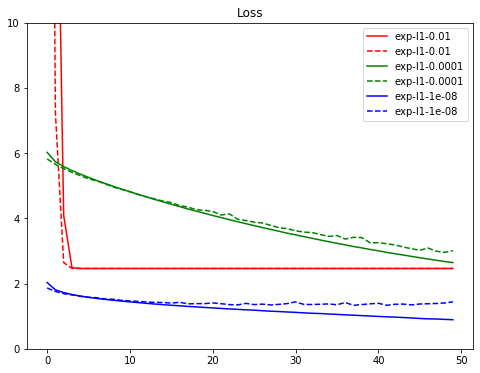

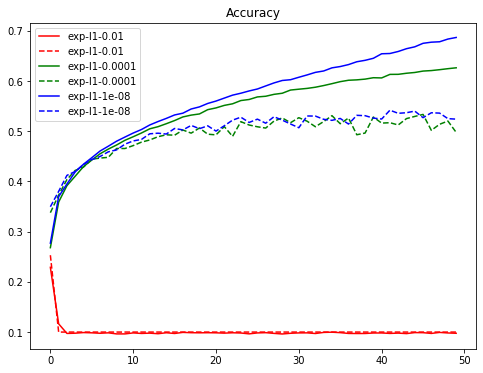

In [14]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 10])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()